<a href="https://colab.research.google.com/github/GlazyevaValentina/Final_Project_GlazyevaVa/blob/main/output/plugins/profile/2023_05_10_20_24_38/new_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://habr.com/ru/companies/nix/articles/342388/

https://github.com/emilwallner/Coloring-greyscale-images

In [ ]:
import keras

from keras import models
from keras import layers
from keras import optimizers

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image

#from keras.engine import Layer
from keras.layers import Layer

from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

#from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose 
# from keras.layers import merge
from tensorflow.keras.layers import Input, Embedding, concatenate, Reshape

from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import TensorBoard 
# from keras.models import Sequential, Model

from tensorflow.keras.models import Sequential, Model

from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
print(keras.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Get images

X = []
# img_width, img_height = 256, 256  # Define the target image width and height

for filename in os.listdir('/content/gdrive/MyDrive/My Diploma/Train/'):
    X.append(img_to_array(load_img('/content/gdrive/MyDrive/My Diploma/Train/'+filename)))
X = np.array(X, dtype=float)

# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain
                                   
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
# inception.graph = tf.get_default_graph()  


inception.graph = tf.compat.v1.get_default_graph()
                                

Instructions for updating:
Colocations handled automatically by placer.


225209952/225209952 [==============================] - 1s 0us/step


In [ ]:
embed_input = Input(shape=(1000,))

In [ ]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 128, 128, 12  73856       ['conv2d_203[0][0]']             
                                8)                                                            

In [ ]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        # embed = inception.predict(grayscaled_rgb_resized)
        embed = inception.__call__(grayscaled_rgb_resized)
    return embed

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [ ]:
#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


In [ ]:
# Train model
tensorboard = TensorBoard(log_dir='/content/gdrive/MyDrive/My Diploma/output')

model.compile(optimizer='adam', loss='mse')
model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=4, steps_per_epoch=2)

Epoch 1/4
2/2 [==============================] - 111s 42s/step - batch: 0.5000 - size: 9.0000 - loss: 0.3463
Epoch 2/4
2/2 [==============================] - 113s 62s/step - batch: 0.5000 - size: 9.0000 - loss: 0.8008
Epoch 3/4
2/2 [==============================] - 118s 61s/step - batch: 0.5000 - size: 9.0000 - loss: 0.0290
Epoch 4/4
2/2 [==============================] - 127s 62s/step - batch: 0.5000 - size: 9.0000 - loss: 0.0073


In [ ]:
#Make a prediction on the unseen images
color_me = []
for filename in os.listdir('/content/gdrive/MyDrive/My Diploma/Test/'):
    color_me.append(img_to_array(load_img('/content/gdrive/MyDrive/My Diploma/Test/'+filename)))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [ ]:
# Test model
# output = model.predict([color_me, color_me_embed])
output = model.predict([color_me, color_me_embed], steps=len(color_me))
output = output * 128

# Output colorizations
for i in range(len(color_me)):
  cur = np.zeros((256, 256, 3))
  cur[:,:,0] = color_me[i][:,:,0]
  cur[:,:,1:] = output[i]
  imsave("/content/gdrive/MyDrive/My Diploma/result1/img_"+str(i)+".png", lab2rgb(cur))


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


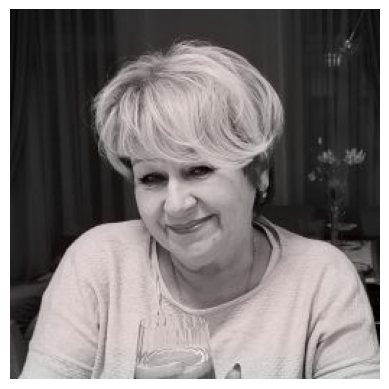

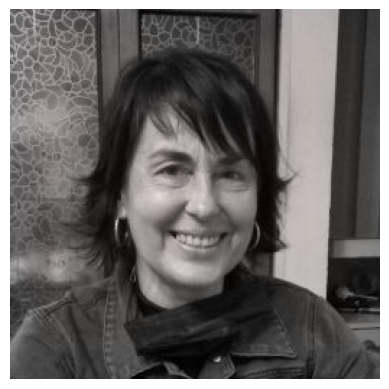

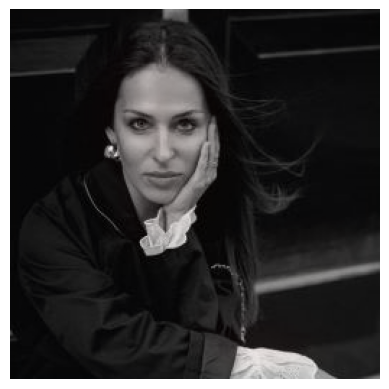

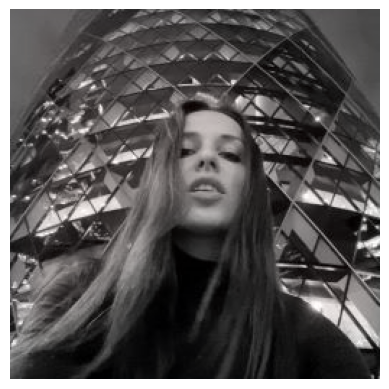

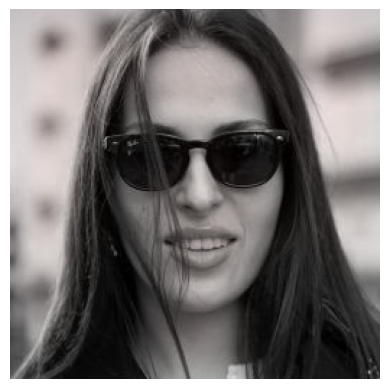

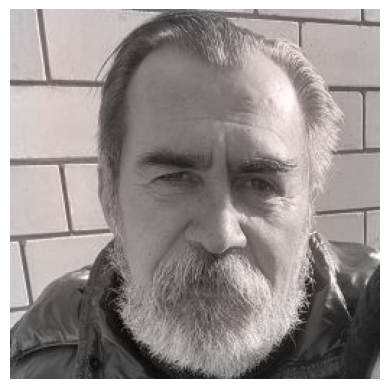

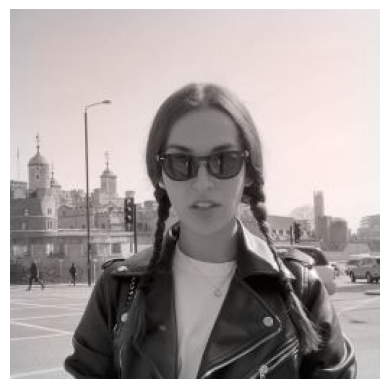

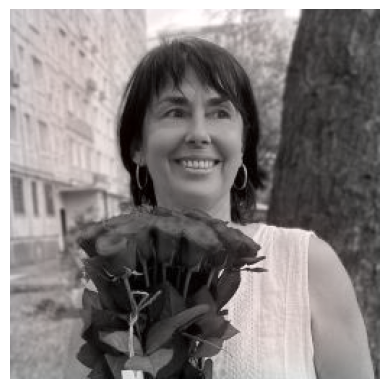

In [ ]:
import matplotlib.pyplot as plt
import os

path = "/content/gdrive/MyDrive/My Diploma/result1"
images = os.listdir(path)

for image in images:
    img_path = os.path.join(path, image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()